## Aligning PPG To ECG

Here we refer to the time window as the frame. Each frame is 0.033 sec front and back (so 0.67 total)

In [1]:
import numpy
import matplotlib.pyplot as plt
fps = 30.323427803


In [1]:
def processECG(filePath):
    f = open(filePath, 'r')
    inputSectionList = f.read().split('\n\n')
    rrSection = inputSectionList[-2]
    rrData = rrSection.split('\n')
    #get rid of header
    rrData = rrData[1:]
    #get rid of the last three sentinel values '3999'
    rrData = rrData[0:len(rrData)-3]
    return rrData
rrL1 = processECG('/home/mong/Desktop/map/map/videos/15012301_GIO.hrm')
rrL2 = processECG('/home/mong/Desktop/map/map/videos/15012301_GLO.hrm')
print(rrL1)

FileNotFoundError: [Errno 2] No such file or directory: '15012301_GIO.hrm'

In [2]:
def readFromFile(fileName):
    l =numpy.loadtxt(fileName)
    return l[0], l[1], l[2]

In [3]:
def detectPeak(colorL, frameThreshold):
    peakL = list()
    colorlistLen = len(colorL)
    for i in range(1, colorlistLen-1):
        biggerThanPrevious = colorL[i] > colorL[i-1]
        biggerThanAfter = colorL[i] > colorL[i+1]
        #if it is a local maximum, then check if it is a RR peak by comparing its maxima interval to frameThreshold
        if biggerThanPrevious and biggerThanAfter:
            for k in range(2, frameThreshold+1):
                if i-k >= 0:
                    if not colorL[i] > colorL[i-k]:
                        #this is not a rr peak
                        break
                if i+k < colorlistLen:
                    if not colorL[i] > colorL[i+k]:
                        #this is not a rr peak
                        break
            else:
                #this IS a rr peak, store the array index
                peakL.append(i)
    return peakL

In [4]:
def constructRRIntervalList(peakL):
    return [ (peakL[i]-peakL[i-1])/fps for i in range(1, len(peakL))]

This function defines the criteria for being a true RR interval.

In [5]:
def isTrueRRInterval(rrInterval):
    if 0.54 <= rrInterval and rrInterval <= 1.0:
        return True
    else:
        return False

We define the percent error as following:

$$\epsilon^{(i)} = \frac{\text{# of wrong RR}}{\text{# of RR}} x100$$

This function detect the amount of errors in a list of RR interval, as judged by function isTrueRRInterval

In [6]:
def getPercentError(rrL):
    errorNum = 0
    for rrInterval in rrL:
        if (not isTrueRRInterval(rrInterval)):
            errorNum += 1
    return 100.0*errorNum/len(rrL) if len(rrL) else 0

This function analyze the rgb txt file of a PPG video and return important information.

In [7]:
def analyzeVideoAndFindPercentErrorList(fileName):
    rErrorL = []
    gErrorL = []
    bErrorL = []
    rL, gL, bL = readFromFile(fileName)
    for frameThreshold in range(1, 26):
        rRRL = constructRRIntervalList(detectPeak(rL, frameThreshold))
        gRRL = constructRRIntervalList(detectPeak(gL, frameThreshold))
        bRRL = constructRRIntervalList(detectPeak(bL, frameThreshold))
        rErrorL.append(getPercentError(rRRL))
        gErrorL.append(getPercentError(gRRL))
        bErrorL.append(getPercentError(bRRL))
    return rErrorL, gErrorL, bErrorL

In [8]:
videoList = ["/home/mong/Desktop/map/map/videos/VID_20150123_172926_F.mp4.txt",
    "/home/mong/Desktop/map/map/videos/VID_20150123_173259_Q.mp4.txt",
    "/home/mong/Desktop/map/map/videos/VID_20150123_173329_F.mp4.txt",
    "/home/mong/Desktop/map/map/videos/VID_20150123_173358_Q.mp4.txt",
    "/home/mong/Desktop/map/map/videos/VID_20150123_173427_F.mp4.txt",
    "/home/mong/Desktop/map/map/videos/VID_20150123_173457_Q.mp4.txt",
    "/home/mong/Desktop/map/map/videos/VID_20150123_173556_Q.mp4.txt",
    "/home/mong/Desktop/map/map/videos/VID_20150123_173629_F.mp4.txt",
    "/home/mong/Desktop/map/map/videos/VID_20150123_173700_Q.mp4.txt",
    "/home/mong/Desktop/map/map/videos/VID_20150123_173757_Q.mp4.txt",
    "/home/mong/Desktop/map/map/videos/VID_20150123_173028_F.mp4.txt",
    "/home/mong/Desktop/map/map/videos/VID_20150123_172857_Q.mp4.txt"]

In [9]:
rAvgErrorL = [0 for i in range(0, 25)]
gAvgErrorL = [0 for i in range(0, 25)]
bAvgErrorL = [0 for i in range(0, 25)]
vidPPGL = {}
for video in videoList:
    rErrorL, gErrorL, bErrorL = analyzeVideoAndFindPercentErrorList(video)
    vidPPGL[video+'|red|'+str(rErrorL.index(min(rErrorL))*2+2)] = min(rErrorL)
def isInRange(begin, end, value):
    return begin <= value and value < end
def numOfVidInBeam(begin, end):
    num = 0
    for vidName in vidPPGL:
        if isInRange(begin, end, vidPPGL[vidName]):
            num += 1
    return num
probabilityArray = [numOfVidInBeam(0,25),
                   numOfVidInBeam(25,50),
                   numOfVidInBeam(50,75),
                   numOfVidInBeam(75,101)]


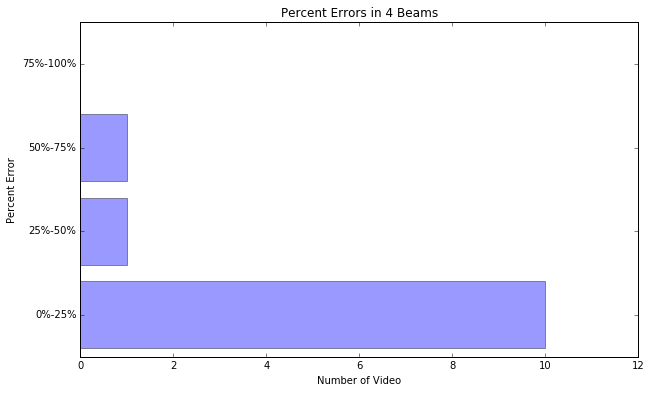

In [10]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.figsize'] = (10, 6)
beams = ('0%-25%', '25%-50%', '50%-75%', '75%-100%')
y_pos = numpy.arange(len(beams))

plt.barh(y_pos, probabilityArray,align='center', alpha=0.4)
plt.yticks(y_pos, beams)
plt.xlabel('Number of Video')
plt.ylabel('Percent Error')
plt.xlim(0, len(videoList))
plt.title('Percent Errors in 4 Beams')
plt.show()

If we define a good video to have percent error less than 10%, then the probability of a video being a good one is:

In [11]:
numOfVidInBeam(0,10)/len(videoList)

0.4166666666666667

But if we define a good video to have percent error less than 25%, then the probability of a video being a good one is:

In [12]:
numOfVidInBeam(0,25)/len(videoList)

0.8333333333333334

In [13]:
for vidName in vidPPGL:
    print(vidName, "   ",vidPPGL[vidName])

/home/mong/Desktop/map/map/videos/VID_20150123_173329_F.mp4.txt|red|6     69.04761904761905
/home/mong/Desktop/map/map/videos/VID_20150123_173700_Q.mp4.txt|red|12     13.793103448275861
/home/mong/Desktop/map/map/videos/VID_20150123_172857_Q.mp4.txt|red|12     6.0606060606060606
/home/mong/Desktop/map/map/videos/VID_20150123_173028_F.mp4.txt|red|8     0.0
/home/mong/Desktop/map/map/videos/VID_20150123_173556_Q.mp4.txt|red|12     12.903225806451612
/home/mong/Desktop/map/map/videos/VID_20150123_173457_Q.mp4.txt|red|10     13.333333333333334
/home/mong/Desktop/map/map/videos/VID_20150123_173427_F.mp4.txt|red|12     6.0606060606060606
/home/mong/Desktop/map/map/videos/VID_20150123_173358_Q.mp4.txt|red|14     6.896551724137931
/home/mong/Desktop/map/map/videos/VID_20150123_173259_Q.mp4.txt|red|12     13.333333333333334
/home/mong/Desktop/map/map/videos/VID_20150123_172926_F.mp4.txt|red|14     2.5641025641025643
/home/mong/Desktop/map/map/videos/VID_20150123_173757_Q.mp4.txt|red|10     13.3